In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import euclidean
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from imputers import KNNImputerMode, KNNImputerMedian

In [57]:
data = pd.read_csv('./Financial Well-Being Survey Data/NFWBS_PUF_2016_data.csv')

print(f'The dataset contains {data.shape[0]} rows and {data.shape[1]} features.')

The dataset contains 6394 rows and 217 features.


In [58]:
data.set_index('PUF_ID', inplace=True)

# Data cleaning

## Dropping irrelevant features

We can remove features that were used for feature engineering

Engineered features: 
- FWBScore: created from FWB questions
- FSscore: created from FS questions
- LMscore: created from FINKKNOWL questions + FKcorrect
- KHscore: created from KHKNOWL questions + KHcorrect
- ON1correct: OBJNUMERACY1
- ON2correct: OBJNUMERACY2

- EMPLOY: one hots
- EMPLOY_9: Perfect collinearity
- Military_status: Redundant with MILITARY

In [59]:
FWB_cols = list(filter(lambda x: 'FWB' in x, data.columns.values))
data.drop(FWB_cols[1:], axis = 1, inplace = True)

FS_cols = list(filter(lambda x: 'FS' in x, data.columns.values))
data.drop(FS_cols[1:], axis = 1, inplace = True)

LM_cols = list(filter(lambda x: 'FINKNOWL' in x, data.columns.values))
data.drop(LM_cols, axis = 1, inplace = True)

FKcorrect_cols = ['FK1correct', 'FK2correct', 'FK3correct']
data.drop(FKcorrect_cols, axis = 1, inplace = True)

KH_cols = list(filter(lambda x: 'KHKNOWL' in x, data.columns.values))
data.drop(KH_cols, axis = 1, inplace = True)

KHcorrect_cols = ['KH1correct', 'KH2correct', 'KH3correct', 'KH4correct', 'KH5correct', 'KH6correct', 'KH7correct', 'KH8correct', 'KH9correct']
data.drop(KHcorrect_cols, axis = 1, inplace = True)

OBJNUMcols = list(filter(lambda x: 'OBJNUMERACY' in x, data.columns.values))
data.drop(OBJNUMcols, axis = 1, inplace = True)

In [60]:
data.drop('EMPLOY', axis = 1, inplace = True) # drop employ because it is already one hot enconded
data.drop('EMPLOY1_9', axis = 1, inplace = True) # drop because of perfect collinearity problem
data.drop('Military_Status', axis = 1, inplace = True) # redundant with MILITARY

All KIDS variables will be excluded due to probable missinterpretation and redudancy with accurate panel data

In [61]:
data.drop(list(filter(lambda x: 'KIDS' in x, data.columns.values)), axis =1, inplace = True)

In [62]:
data.head()

,sample,fpl,SWB_1,SWB_2,SWB_3,FWBscore,FSscore,SUBKNOWL1,ACT1_1,ACT1_2,...,PPMSACAT,PPREG4,PPREG9,PPT01,PPT25,PPT612,PPT1317,PPT18OV,PCTLT200FPL,finalwt
PUF_ID,,,,,,,,,,,,,,,,,,,,,
10350,2,3,5,5,6,55,44,5,4,3,...,1,4,8,0,0,0,0,1,0,0.367292
7740,1,3,6,6,6,51,43,5,4,3,...,1,2,3,0,0,0,0,2,0,1.327561
13699,1,3,4,3,4,49,42,5,3,3,...,1,4,9,0,0,0,1,2,1,0.835156
7267,1,3,6,6,6,49,42,-1,-1,-1,...,1,3,7,0,0,0,0,1,0,1.410871
7375,1,3,4,4,4,49,42,4,3,3,...,1,2,4,0,0,1,0,4,1,4.260668


## Missing values

## __-5: County not known__


Use PPREG9, PPINCIMP and PPEDUC to impute PCTLT200FPL

PPEDUC: ordinal
<br>
PPINCIMP: ordinal
<br>
PPREG9: categorical

distance to find nearest neighbors: euclidean for PPINC, PPEDUC  + one hot for PPREG9

In [63]:
# replace by missing values
data = data.replace(-5, np.nan)

In [64]:
nrows = data[data['PCTLT200FPL'].isna()].shape[0]
print(f'nr of rows with missing value: {nrows}')

nr of rows with missing value: 395


In [65]:
def distance(X, Y, missing_values = np.nan):
    
    X[np.isnan(X)] = 0
    Y[np.isnan(Y)] = 0

    eucl_dist = euclidean(X[[0, 1]], Y[[0, 1]])

    return eucl_dist + (X[2] != Y[2])

In [66]:
imputer = KNNImputerMode(n_neighbors = 5, metric = distance)

cols = ['PPEDUC', 'PPINCIMP', 'PPREG9', 'PCTLT200FPL']

# scale numerical features
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data[['PPEDUC', 'PPINCIMP']])
scaled_data = pd.DataFrame(scaled_data, columns = ['PPEDUC', 'PPINCIMP'], index = data.index)
# join with other columns
scaled_data = pd.concat([scaled_data, data[['PPREG9', 'PCTLT200FPL']]], axis = 1)

new_data = imputer.fit_transform(scaled_data)

new_data = pd.DataFrame(new_data, columns = cols, index = data.index)

/home/ines/Desktop/ims_grant/imputers.py:22: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  return np.ravel(mode(donors, axis=1).mode)


In [67]:
data['PCTLT200FPL'] = new_data['PCTLT200FPL'].copy()

In [68]:
data['PCTLT200FPL'].value_counts()

0.0    4835
1.0    1559
Name: PCTLT200FPL, dtype: int64

## __-4: Response not written to the database due to error__

In [69]:
data[(data == -4).any(axis = 1)]

,sample,fpl,SWB_1,SWB_2,SWB_3,FWBscore,FSscore,SUBKNOWL1,ACT1_1,ACT1_2,...,PPMSACAT,PPREG4,PPREG9,PPT01,PPT25,PPT612,PPT1317,PPT18OV,PCTLT200FPL,finalwt
PUF_ID,,,,,,,,,,,,,,,,,,,,,
12173,1,3,-4,-4,-4,-4,48,7,4,3,...,1,3,5,0,0,0,0,1,0.0,1.253964


In [70]:
data.drop(12173, axis = 0, inplace = True)

## __-3: Invalid response/ Incoherent data__

- Replace -3 with -2 for SOCSEC2 because -3 are caused by invalid age, therefore -2 is the adequate label.
- Replace -3 with the mode for SOCSEC3

SOCSEC2

In [71]:
valid_data = data[data['SOCSEC2'] > 0]

In [72]:
data.loc[data['SOCSEC2'] == -3, 'SOCSEC2'] = valid_data['SOCSEC2'].mode()[0]

In [73]:
data['SOCSEC2'].value_counts()

-2     4527
 62     905
 65     459
 66     159
 63     130
 64      68
 67      55
 70      51
 68      19
-1       12
 69       8
Name: SOCSEC2, dtype: int64

SOCSEC3

In [74]:
# age of people with invalid answers
data.loc[data['SOCSEC3'] == -3, 'agecat'].value_counts()

4    25
3    15
2    14
5    11
1     3
Name: agecat, dtype: int64

In [75]:
data.loc[data['SOCSEC3'] >= 61, 'agecat'].value_counts()

2    1056
4    1027
3     783
5     679
1     387
Name: agecat, dtype: int64

In [76]:
# people who have not start receiving social security benefits
valid_data = data[(data['SOCSEC3'] != -2) & (data['SOCSEC3'] != -3) & (data['SOCSEC3'] != -1)]

In [77]:
data.loc[data['SOCSEC3'] == -3, 'SOCSEC3'] = valid_data['SOCSEC3'].mode()[0]

In [78]:
data['SOCSEC3'].value_counts()

-2     2253
 65    1289
 70     723
 67     451
 61     407
 62     372
 71     364
 68     160
-1      140
 66     118
 63      51
 69      41
 64      24
Name: SOCSEC3, dtype: int64

## Others
__-1: Not answered/ Left blank__
<br>
__98: Don't know__
<br>
__99: Prefer not to say__

First, let's replace the missing values with NaN

In [79]:
data = data.replace(-1, np.nan)

# replace 98 and 99 only on the columns with code
data[['HOUSERANGES', 'VALUERANGES', 'MORTGAGE', 'SAVINGSRANGES']] = data[['HOUSERANGES', 'VALUERANGES', 'MORTGAGE', 'SAVINGSRANGES']].replace(98, np.nan)
data[['HOUSERANGES', 'VALUERANGES', 'MORTGAGE', 'SAVINGSRANGES']] = data[['HOUSERANGES', 'VALUERANGES', 'MORTGAGE', 'SAVINGSRANGES']].replace(99, np.nan)

In [80]:
data[data.isna().sum(axis = 1) >= 5]

,sample,fpl,SWB_1,SWB_2,SWB_3,FWBscore,FSscore,SUBKNOWL1,ACT1_1,ACT1_2,...,PPMSACAT,PPREG4,PPREG9,PPT01,PPT25,PPT612,PPT1317,PPT18OV,PCTLT200FPL,finalwt
PUF_ID,,,,,,,,,,,,,,,,,,,,,
7267,1,3,6.0,6.0,6.0,49.0,42.0,NaN,NaN,NaN,...,1,3,7,0,0,0,0,1,0.0,1.410871
9182,1,3,6.0,NaN,NaN,50.0,43.0,4.0,4.0,3.0,...,1,4,9,0,0,0,0,2,0.0,0.647301
11082,1,3,6.0,6.0,5.0,62.0,55.0,4.0,5.0,4.0,...,1,3,5,0,0,0,0,3,0.0,0.455829
8309,2,3,3.0,4.0,2.0,49.0,37.0,NaN,4.0,3.0,...,1,3,5,0,0,0,0,1,0.0,0.597089
9916,1,3,7.0,6.0,6.0,62.0,46.0,4.0,5.0,3.0,...,1,3,5,0,0,0,1,2,0.0,0.637269
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13222,3,2,7.0,7.0,7.0,40.0,45.0,4.0,3.0,2.0,...,1,3,7,0,0,0,0,4,0.0,1.232251
11078,3,1,3.0,4.0,5.0,26.0,44.0,4.0,3.0,3.0,...,1,2,3,0,1,0,0,1,0.0,1.379959
12353,1,3,5.0,7.0,3.0,62.0,26.0,4.0,3.0,3.0,...,1,3,5,0,0,0,0,2,0.0,1.745759


Now let's drop the rows with more than 5 missing values

In [81]:
data.drop(data[data.isna().sum(axis = 1) >= 5].index, axis = 0, inplace = True)

In [82]:
data.shape

(6096, 163)

Now we impute the missing values of the remaining observations

__Central tendency imputations__

Given the large size of the dataset, for columns with less than 100 missing values we will use measures of central tendency:

__Ordinal__

SWB_1, SWB_2, SUBKNOWL1, ACT1_2, ASK1_1, SUBNUMERACY1, CONSPROTECT1, ABSORBSHOCK, PAREDUC, MATERIALISM_3, HEALTH, SELFCONTROL_1, SELFCONTROL_2, SELFCONTROL_3, OUTLOOK_1, OUTLOOK_2, PEM, LIFEEXPECT: skewed -> median

SWB_3, ACT1_1, SAVEHABIT, FRUGALITY, ENDSMEET, CONSPROTECT2, MATHARDSHIP_6, HOUSESAT: staricase -> mode

ASK1_2, SUBNUMERACY2, CHANGEABLE, GOALCONF, EARNERS, VOLATILITY, MATERIALISM,_1, MATERIALISM_2, SCFHORIZON, DISTRESS, HHEDUC, RETIRE (cuidado com -2): gaussian distribution -> mode

__Categorical__

FINGOALS, AUTOMATED_1, AUTOMATED_2, HOUSING, LIVINGARRANGEMENT, CONSPROTECT3, SNAP, COLLECT, REJECTED_1, REJECTED_2, BENEFITS_3, BENEFITS_4, BENEFITS_5, FRAUD2, COVERCOSTS, MANAGE2, PAIDHELP (cuidado com -2), FINSOC2_3, FINSOC2_5, FINSOC2_6, DISCOUNT, MEMLOSS, SOCSEC1, SOCSEC2, SOCSEC3 (cuidado com -3 e -2) MILITARY: mode

Let's see the observations where it is not known if the respondant has already started recieving social security benefits

In [83]:
data.loc[data['SOCSEC1'].isna(), ['SOCSEC1', 'SOCSEC2', 'SOCSEC3']] # just drop because is almost impossible to know and has implications on two more answers

,SOCSEC1,SOCSEC2,SOCSEC3
PUF_ID,,,
10357,NaN,-2.0,-2.0
11275,NaN,-2.0,-2.0
13281,NaN,-2.0,-2.0
12889,NaN,-2.0,-2.0


In [84]:
data.drop(data[data['SOCSEC1'].isna()].index, axis = 0, inplace = True)

And now for people who have started receiving social security benefits but did not respond to the age. Everything looks coherent

In [85]:
data.loc[data['SOCSEC2'].isna(), ['SOCSEC1', 'SOCSEC2', 'SOCSEC3']]

,SOCSEC1,SOCSEC2,SOCSEC3
PUF_ID,,,
14093,1.0,NaN,-2.0
13330,1.0,NaN,-2.0
13604,1.0,NaN,-2.0
13728,1.0,NaN,-2.0
12982,1.0,NaN,-2.0
12279,1.0,NaN,-2.0
12470,1.0,NaN,-2.0
11348,1.0,NaN,-2.0


Lastly, people who have not started receiving social security benefits wither because they are younger than 62 or because they are older but did not start receiving.

Data also looks coherent.

In [86]:
data.loc[data['SOCSEC3'].isna(), ['SOCSEC1', 'SOCSEC2', 'SOCSEC3']]

,SOCSEC1,SOCSEC2,SOCSEC3
PUF_ID,,,
12163,-2.0,-2.0,NaN
8956,-2.0,-2.0,NaN
11503,-2.0,-2.0,NaN
9207,-2.0,-2.0,NaN
8009,-2.0,-2.0,NaN
...,...,...,...
14060,-2.0,-2.0,NaN
12231,-2.0,-2.0,NaN
13938,-2.0,-2.0,NaN


Just antother coherence check: people with retire != -2 should have employ1_8 positive

In [87]:
data.loc[(data['RETIRE'] >= 1) , 'EMPLOY1_8'].value_counts()

1    1776
Name: EMPLOY1_8, dtype: int64

In [90]:
data.loc[data['HOUSING'].isna(), ['HOUSING', 'VALUERANGES', 'MORTGAGE']] # 12 observations with no information about housing

# better to drop because VALUERANGES and MORTGAGE depend on this one and it is impossible to infer

,HOUSING,VALUERANGES,MORTGAGE
PUF_ID,,,


In [89]:
data.drop(data[data['HOUSING'].isna()].index, axis = 0, inplace = True)

In [93]:
skewed_ordinal = ['SWB_1', 'SWB_2', 'SUBKNOWL1', 'ACT1_2', 'ASK1_1', 'SUBNUMERACY1', 'CONSPROTECT1', 'ABSORBSHOCK', 'PAREDUC', 'MATERIALISM_3', 'HEALTH', 'SELFCONTROL_1', 'SELFCONTROL_2', 'SELFCONTROL_3', 'OUTLOOK_1', 'OUTLOOK_2', 'PEM', 'LIFEEXPECT']

for feat in skewed_ordinal:
    data.loc[data[feat].isna(), feat] = data[feat].median()

staircase_ordinal = ['SWB_3', 'ACT1_1', 'SAVEHABIT', 'FRUGALITY', 'ENDSMEET', 'CONSPROTECT2', 'MATHARDSHIP_6', 'HOUSESAT']

for feat in staircase_ordinal:
    data.loc[data[feat].isna(), feat] = data[feat].mode()[0]

# excluding RETIRE
gaussian_ordinal = ['ASK1_2', 'SUBNUMERACY2', 'CHANGEABLE', 'GOALCONF', 'EARNERS', 'VOLATILITY', 'MATERIALISM_1', 'MATERIALISM_2', 'SCFHORIZON', 'DISTRESS', 'HHEDUC']

for feat in gaussian_ordinal:
    data.loc[data[feat].isna(), feat] = data[feat].mode()[0]

# excluding PAIDHELP, SOCSEC2 and SOCSEC3 because they have -2 values
categorical = ['FINGOALS', 'AUTOMATED_1', 'AUTOMATED_2', 'LIVINGARRANGEMENT', 'CONSPROTECT3', 'SNAP', 'COLLECT', 'REJECTED_1', 'REJECTED_2', 'BENEFITS_3', 'BENEFITS_4', 'BENEFITS_5', 'FRAUD2', 'COVERCOSTS', 'MANAGE2', 'FINSOC2_3', 'FINSOC2_5', 'FINSOC2_6', 'DISCOUNT', 'MEMLOSS', 'MILITARY']

for feat in categorical:
    data.loc[data[feat].isna(), feat] = data[feat].mode()[0]
    
# ex+ections with -2 answers
valid_data = data[data['RETIRE'] >= 1].copy()
data.loc[data['RETIRE'].isna(), 'RETIRE'] = valid_data['RETIRE'].mode()[0]

valid_data = data[data['SOCSEC2'] != -2].copy()
data.loc[data['SOCSEC2'].isna(), 'SOCSEC2'] = valid_data['SOCSEC2'].mode()[0]

valid_data = data[data['SOCSEC3'] != -2].copy()
data.loc[data['SOCSEC3'].isna(), 'SOCSEC3'] = valid_data['SOCSEC3'].mode()[0]

valid_data = data[data['PAIDHELP'] != -2].copy()
data.loc[data['PAIDHELP'].isna(), 'PAIDHELP'] = valid_data['PAIDHELP'].mode()[0]


In [94]:
data[skewed_ordinal + gaussian_ordinal + staircase_ordinal + categorical].isna().sum().sum()

0

Columns that still have missing values (have more than 100 missing values)

In [95]:
data.columns[data.isna().sum() > 0]

Index(['HOUSERANGES', 'VALUERANGES', 'MORTGAGE', 'SAVINGSRANGES', 'BORROW_1',
       'BORROW_2', 'HSLOC', 'CONNECT'],
      dtype='object')

__Other imputation approaches__

__HOUSERANGES__

'About how much do you pay for your home each month?'

Impute with KNNImputer:


COLLECT: binary
<br>
HOUSING: categorical
<br>
HOUSESAT: ordinal
<br>
agecat: ordinal
<br>
PPINCIMP: ordinal
<br>
PPEDUC: ordinal
<br>
PPHHSIZE: ordinal

In [96]:
data[data['HOUSERANGES'].isna()].shape[0]

762

In [106]:
def distance(X, Y, missing_values = np.nan):
    X[np.isnan(X)] = 0
    Y[np.isnan(Y)] = 0

    eucl_dist = euclidean(X[[0, 1, 2, 3, 4]], Y[[0, 1, 2, 3, 4]])

    return eucl_dist + (X[5] != Y[5]) + (X[6] != Y[6])

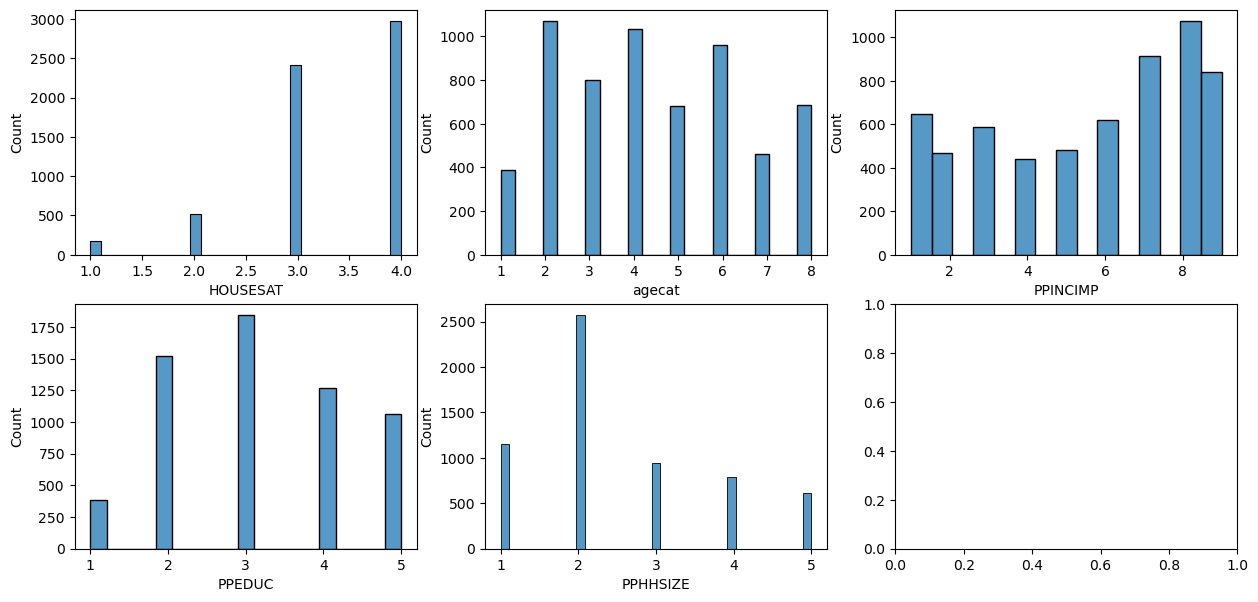

In [105]:
num_cols = ['HOUSESAT', 'agecat', 'PPINCIMP', 'PPEDUC', 'PPHHSIZE']

# plot the distribution of the numerical features
fig, ax = plt.subplots(2, 3, figsize = (15, 7))
for i, col in enumerate(num_cols):
    sns.histplot(data[col], ax = ax[i//3, i%3])

In [108]:
imputer = KNNImputerMode(n_neighbors = 5, metric = distance)

# Standard Scaler to scale the FWBscore
scaler = StandardScaler()
scaled_ppeduc = scaler.fit_transform(data[['PPEDUC']])
scaled_ppeduc = pd.DataFrame(scaled_ppeduc, columns = ['PPEDC'], index = data.index)

# MinMax Scaler to scale the rest of the numerical features
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data[['HOUSESAT', 'agecat', 'PPINCIMP', 'PPHHSIZE']])
scaled_data = pd.DataFrame(scaled_data, columns = ['HOUSESAT', 'agecat', 'PPINCIMP', 'PPHHSIZE'], index = data.index)

scaled_data = pd.concat([scaled_ppeduc, scaled_data, data[['COLLECT', 'HOUSING', 'HOUSERANGES']]], axis = 1)

new_data = imputer.fit_transform(scaled_data)
new_data = pd.DataFrame(new_data, columns = scaled_data.columns, index = scaled_data.index)

/home/ines/Desktop/ims_grant/imputers.py:22: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  return np.ravel(mode(donors, axis=1).mode)


In [110]:
data['HOUSERANGES'] = new_data['HOUSERANGES'].copy()

<Axes: xlabel='HOUSERANGES', ylabel='count'>

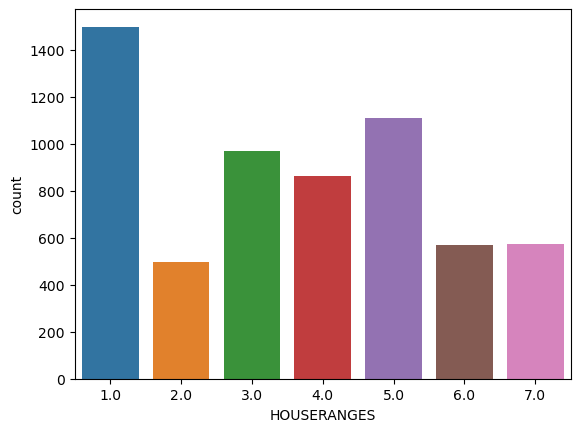

In [112]:
sns.countplot(x = 'HOUSERANGES', data = data)

# the distribution remains similar to the original one before imputation

__VALUERANGES__

'If you were to sell your home today, what do you think it would be worth?'

Impute using KNN:

HOUSERANGES: ordinal
<br>
HOUSESAT: ordinal
<br>
PPINCIMP: ordinal
<br>
MORTGAGE: ordinal

distance: euclidean

In [115]:
data[data['VALUERANGES'].isna()].shape[0]

185

In [116]:
data.loc[data['VALUERANGES'] != -2, 'VALUERANGES'].value_counts()

2.0    1023
1.0    1008
3.0     968
4.0     795
Name: VALUERANGES, dtype: int64

In [117]:
valid_data = data[data['VALUERANGES'] != -2]

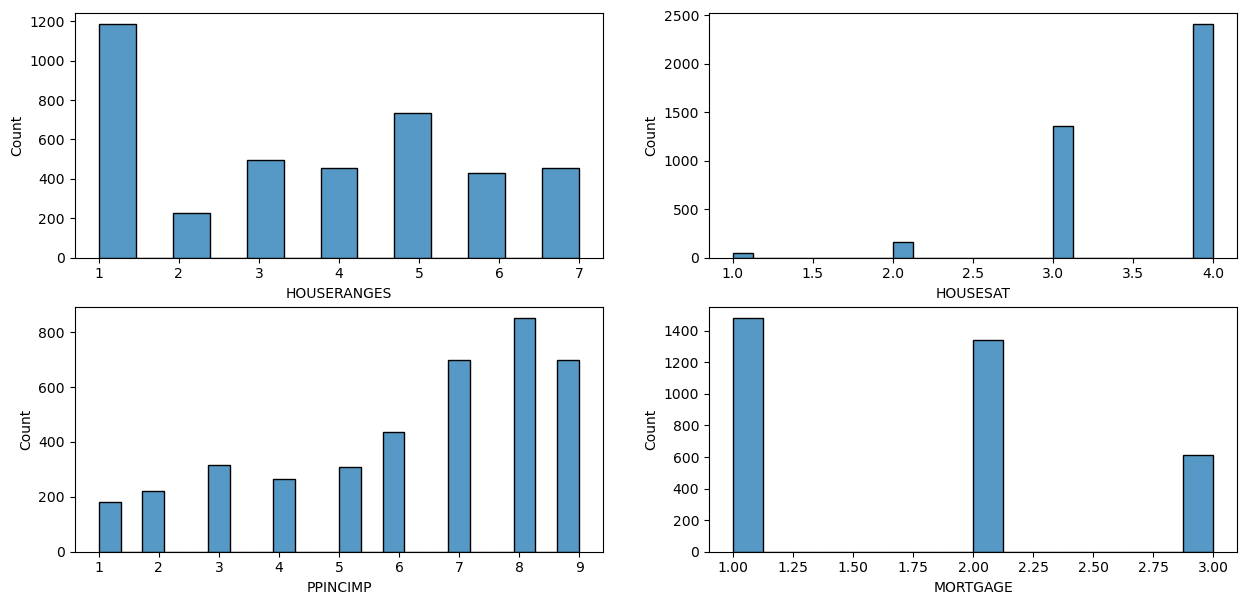

In [118]:
# plot the distribution of the numerical features
fig, ax = plt.subplots(2, 2, figsize = (15, 7))

cols = ['HOUSERANGES', 'HOUSESAT', 'PPINCIMP', 'MORTGAGE']

for i, col in enumerate(cols):
    sns.histplot(valid_data[col], ax = ax[i//2, i%2])

In [119]:
cols = ['HOUSERANGES', 'HOUSESAT', 'PPINCIMP', 'MORTGAGE']

# scale numerical features
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(valid_data[cols])
scaled_data = pd.DataFrame(scaled_data, columns = cols, index = valid_data.index)

scaled_data = pd.concat([scaled_data, valid_data[['VALUERANGES']]], axis = 1)


imputer = KNNImputerMode(n_neighbors = 5)
new_data = imputer.fit_transform(scaled_data)

new_data = pd.DataFrame(new_data, columns = scaled_data.columns, index = scaled_data.index)

/home/ines/Desktop/ims_grant/imputers.py:22: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  return np.ravel(mode(donors, axis=1).mode)


In [120]:
data.loc[data['VALUERANGES'].isna(), 'VALUERANGES'] = new_data.loc[data['VALUERANGES'].isna(), 'VALUERANGES'].copy()

In [121]:
data['VALUERANGES'].isna().sum()

0

<Axes: xlabel='VALUERANGES', ylabel='count'>

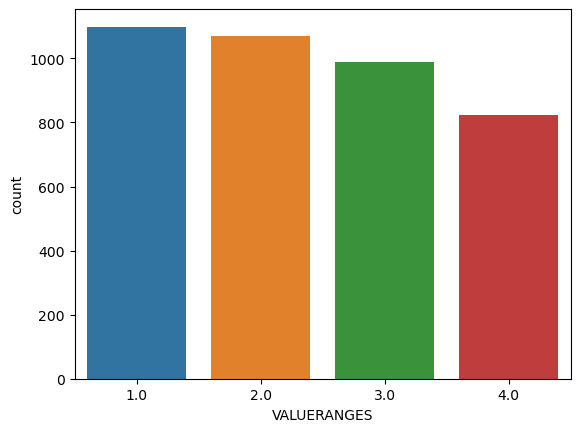

In [122]:
sns.countplot(x = 'VALUERANGES', data = data[data['VALUERANGES'] != -2])

Again, the distribution remains really similar to the original one

__MORTGAGE__

'What do you owe on your home today?'

In [123]:
data[data['MORTGAGE'].isna()].shape[0]

545

In [124]:
valid_data = data[data['MORTGAGE'] != -2]

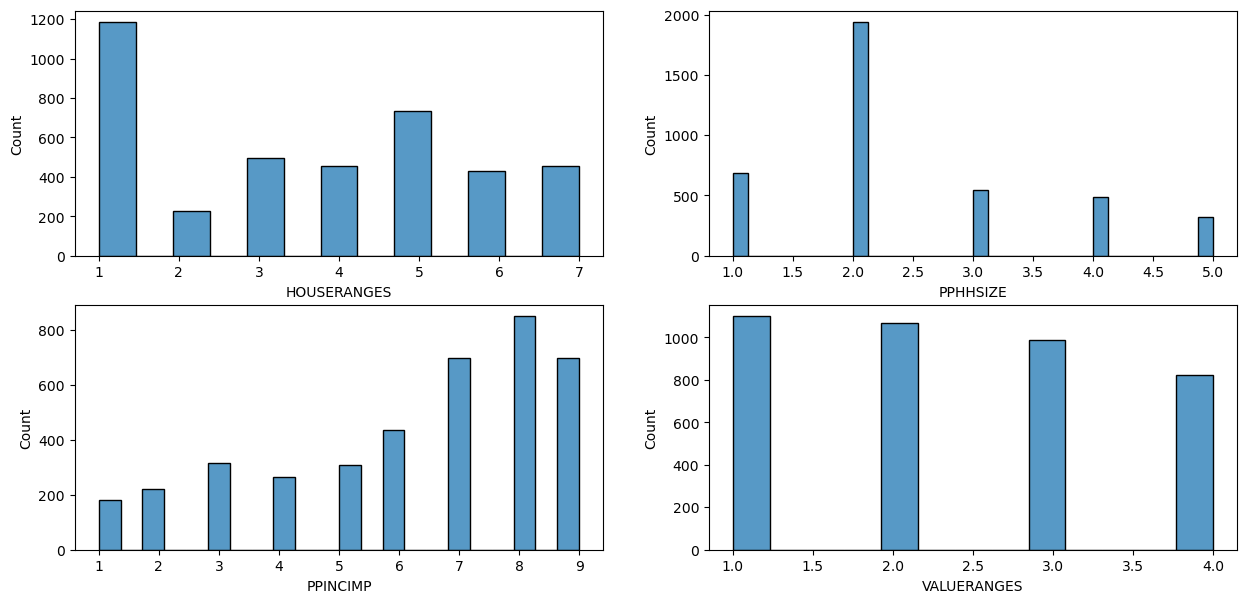

In [126]:
# plot the distribution of the numerical features

cols = ['HOUSERANGES', 'PPHHSIZE', 'PPINCIMP', 'VALUERANGES']

fig, ax = plt.subplots(2, 2, figsize = (15, 7))

for i, col in enumerate(cols):
    sns.histplot(valid_data[col], ax = ax[i//2, i%2])

In [127]:
cols = ['HOUSERANGES', 'PPHHSIZE', 'PPINCIMP', 'VALUERANGES']

# scale numerical features
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(valid_data[cols])
scaled_data = pd.DataFrame(scaled_data, columns = cols, index = valid_data.index)

scaled_data = pd.concat([scaled_data, valid_data[['MORTGAGE']]], axis = 1)

imputer = KNNImputerMode(n_neighbors = 5)
new_data = imputer.fit_transform(scaled_data)

new_data = pd.DataFrame(new_data, columns = scaled_data.columns, index = scaled_data.index)

/home/ines/Desktop/ims_grant/imputers.py:22: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  return np.ravel(mode(donors, axis=1).mode)


In [128]:
data.loc[data['MORTGAGE'].isna(), 'MORTGAGE'] = new_data.loc[data['MORTGAGE'].isna(), 'MORTGAGE'].copy()

<Axes: xlabel='MORTGAGE', ylabel='count'>

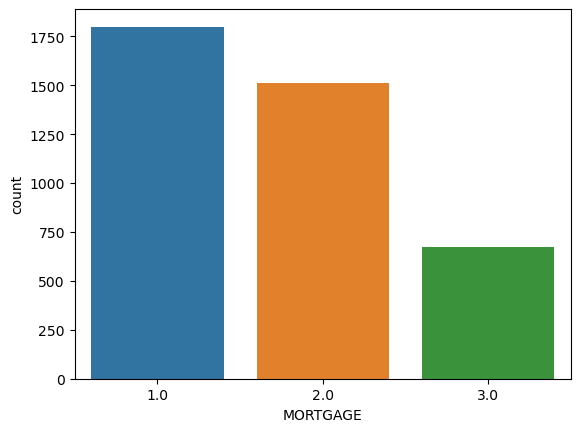

In [129]:
sns.countplot(x = 'MORTGAGE', data = data[data['MORTGAGE'] != -2])

__SAVINGSRANGES__

'How much money do you have in savings today?'

KNN imputation using:

SAVEHABIT: ordinal
<br>
PRODHAVE_1: binary
<br>
MATHARDSHIP_1: ordinal
<br>
COLLECT: categorical
<br>
PPINCIMP: ordinal

distance: euclidean + hamming

In [136]:
data[data['SAVINGSRANGES'].isna()].shape[0]

969

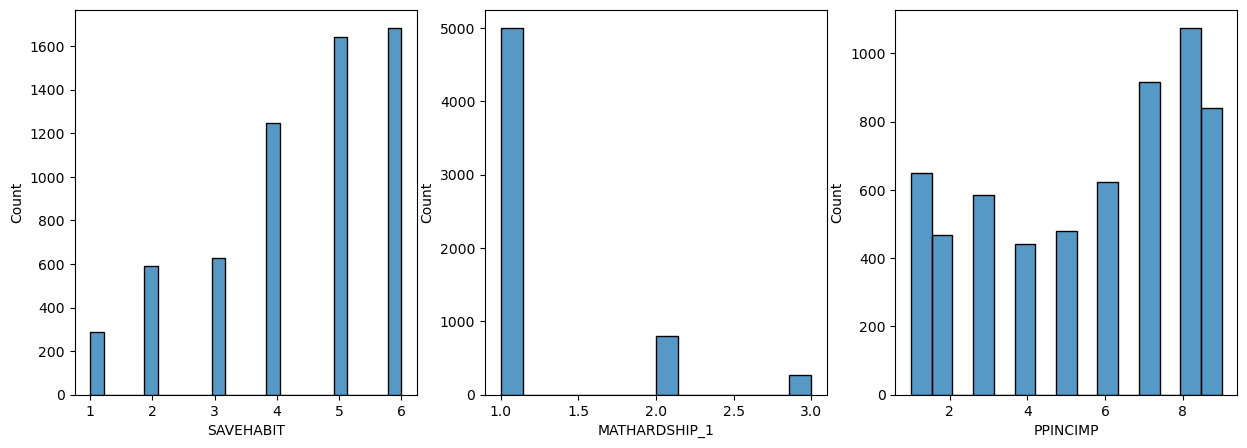

In [137]:
num_cols = ['SAVEHABIT', 'MATHARDSHIP_1', 'PPINCIMP']

# plot the distribution of the numerical features
fig, ax = plt.subplots(1, 3, figsize = (15, 5))
for i, col in enumerate(num_cols):
    sns.histplot(data[col], ax = ax[i%3])

In [139]:
def distance(X, Y, missing_values = np.nan):
    X[np.isnan(X)] = 0
    Y[np.isnan(Y)] = 0

    eucl_dist = euclidean(X[[0, 1, 2]], Y[[0, 1, 2]])

    return eucl_dist + (X[3] != Y[3]) + (X[4] != Y[4])

In [140]:
# scale numerical features
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data[num_cols])
scaled_data = pd.DataFrame(scaled_data, columns = num_cols, index = data.index)

scaled_data = pd.concat([scaled_data, data[['COLLECT', 'PRODHAVE_1', 'SAVINGSRANGES']]], axis = 1)

imputer = KNNImputerMode(n_neighbors = 5, metric = distance)
new_data = imputer.fit_transform(scaled_data)

new_data = pd.DataFrame(new_data, columns = scaled_data.columns, index = scaled_data.index)

/home/ines/Desktop/ims_grant/imputers.py:22: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  return np.ravel(mode(donors, axis=1).mode)


In [141]:
data['SAVINGSRANGES'] = new_data['SAVINGSRANGES'].copy()

__BORROW_1__

'My friends or family would lend me the money and expect me to repay them'

In [142]:
data[data['BORROW_1'].isna()].shape[0]

116

In [143]:
data.loc[data['BORROW_1'].isna(), 'BORROW_1'] = data['BORROW_1'].mode()[0]

__BORROW_2__

'My friends or family would give me the money with no expectation of'

In [144]:
data[data['BORROW_2'].isna()].shape[0]

210

In [145]:
data.loc[data['BORROW_2'].isna(), 'BORROW_2'] = data['BORROW_2'].mode()[0]

__HSLOC__

'Where did you live at age 17?'

In [146]:
data[data['HSLOC'].isna()].shape[0]

532

In [147]:
data.loc[data['HSLOC'].isna(), 'HSLOC'] = data['HSLOC'].mode()[0]

__CONNECT__

Psychological connectedness

KNN imputation using:

PPINCIMP: ordinal
<br>
DISSTRESS: ordinal
<br>
agecat: ordinal
<br>
CHANGEABLE: ordinal

distance: euclidean

In [148]:
data[data['CONNECT'].isna()].shape[0]

150

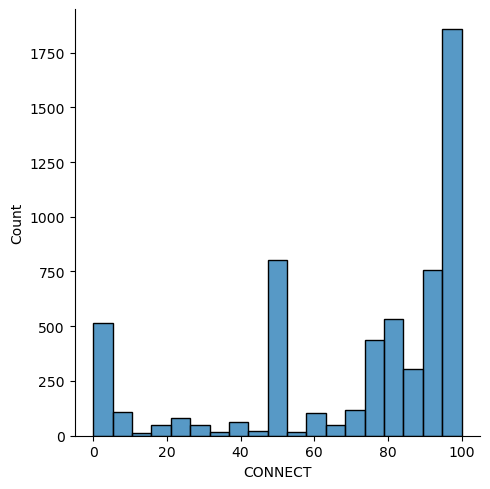

In [348]:
sns.displot(x = 'CONNECT', data = data)

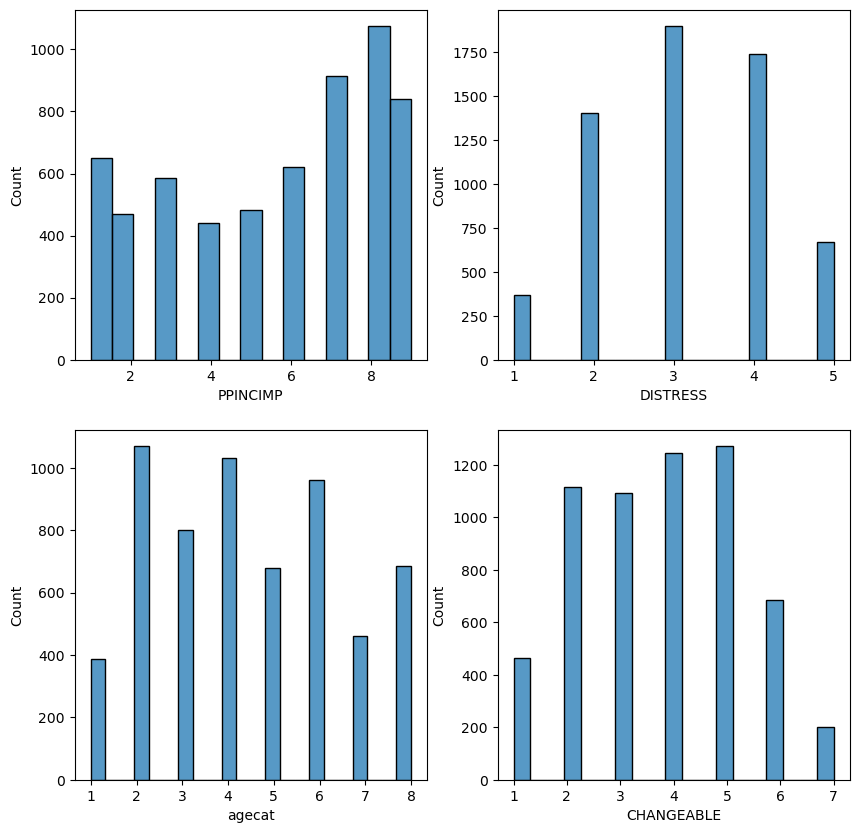

In [149]:
# plot the distribution of the numerical features
num_cols = ['PPINCIMP', 'DISTRESS', 'agecat', 'CHANGEABLE']

fig, ax = plt.subplots(2, 2, figsize = (15, 7))
for i, col in enumerate(num_cols):
    sns.histplot(data[col], ax = ax[i//2, i%2])

In [350]:
# scale numerical features with gaussian distribution
std_cols = ['DISTRESS', 'CHANGEABLE']
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data[std_cols])
scaled_data = pd.DataFrame(scaled_data, columns = std_cols, index = data.index)

# scale numerical features with non gaussian distribution
cols = ['PPINCIMP', 'agecat']
scaler = MinMaxScaler()
scaled_minmax = scaler.fit_transform(data[cols])
scaled_minmax = pd.DataFrame(scaled_minmax, columns = cols, index = data.index)

scaled_data = pd.concat([scaled_data, scaled_minmax, data[['CONNECT']]], axis = 1)

# Impute with median
imputer = KNNImputerMedian(n_neighbors = 5)
new_data = imputer.fit_transform(scaled_data)

new_data = pd.DataFrame(new_data, columns = scaled_data.columns, index = scaled_data.index)

/home/inesmcm/miniconda3/envs/functionalenv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


In [351]:
data['CONNECT'] = new_data['CONNECT'].copy()

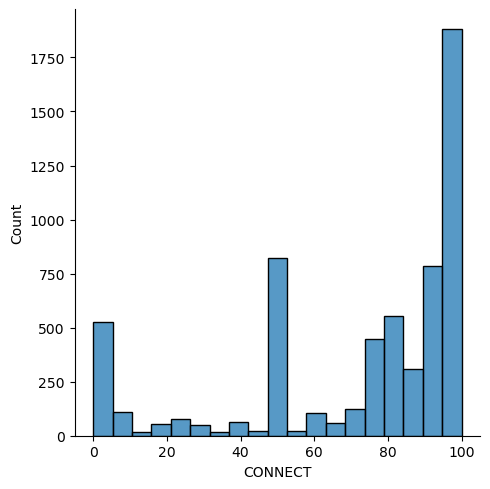

In [352]:
sns.displot(x = 'CONNECT', data = data)

__LIFEEXPECT__


'How likely do you believe it is that you will live beyond age 75?'

KNN Imputation usign variables:

HEALTH: ordinal
<br>
SWB_2: ordinal
<br>
DISTRESS: ordinal

distance: euclidean


In [353]:
data[data['LIFEEXPECT'].isna()].shape[0]

42

In [354]:
data.loc[data['LIFEEXPECT'] >= 0, 'agecat'].value_counts() # 92 people with agecat == 8-> people who are exactly 75 years old

2    1052
4    1025
6     945
3     788
5     672
7     459
1     381
8      99
Name: agecat, dtype: int64

In [355]:
data.loc[data['LIFEEXPECT'].isna(), 'agecat'].value_counts()
# when agecat == 8, age > 75, so let's set probability to the mean of people with agecat == 8

2    15
3     9
6     5
4     5
1     5
5     3
Name: agecat, dtype: int64

In [356]:
round(data.loc[(data['agecat'] == 8) & (data['LIFEEXPECT'] != -2), 'LIFEEXPECT'].mean())

98

In [357]:
data.loc[(data['LIFEEXPECT'].isna()) & (data['agecat'] == 8), 'LIFEEXPECT'] = round(data.loc[(data['agecat'] == 8) & (data['LIFEEXPECT'] != -2), 'LIFEEXPECT'].mean())

In [358]:
data.loc[data['LIFEEXPECT'].isna(), 'agecat'].value_counts()

2    15
3     9
6     5
4     5
1     5
5     3
Name: agecat, dtype: int64

In [359]:
valid_data = data[data['LIFEEXPECT'] != -2]

/home/inesmcm/miniconda3/envs/functionalenv/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/inesmcm/miniconda3/envs/functionalenv/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/inesmcm/miniconda3/envs/functionalenv/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either 

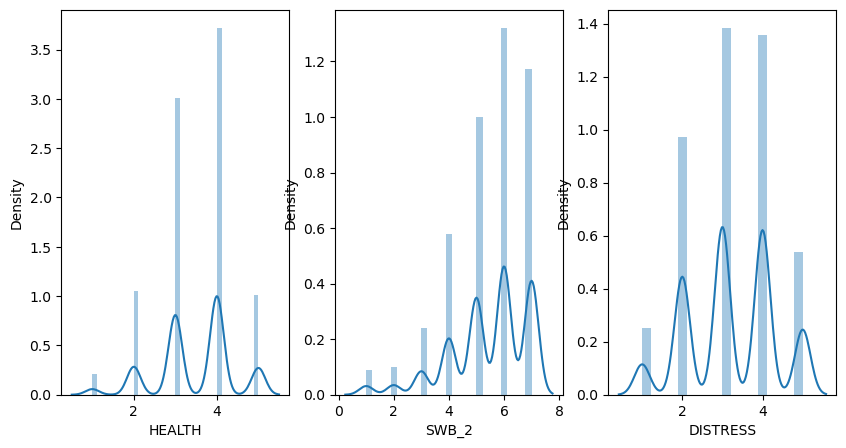

In [360]:
# plot the distribution of the numerical features
cols = ['HEALTH', 'SWB_2', 'DISTRESS']

fig, ax = plt.subplots(1, 3, figsize = (10, 5))
for i, col in enumerate(cols):
    sns.distplot(valid_data[col], ax = ax[i])

In [361]:
imputer = KNNImputerMedian(n_neighbors = 5)

gaussian_cols = ['DISTRESS']
scaler = StandardScaler()
scaled_data = scaler.fit_transform(valid_data[gaussian_cols])
scaled_data = pd.DataFrame(scaled_data, columns = gaussian_cols, index = valid_data.index)

cols = ['HEALTH', 'SWB_2']
scaler = MinMaxScaler()
scaled_minmax = scaler.fit_transform(valid_data[cols])
scaled_minmax = pd.DataFrame(scaled_minmax, columns = cols, index = valid_data.index)

scaled_data = pd.concat([scaled_data, scaled_minmax, valid_data[['LIFEEXPECT']]], axis = 1)

new_data = imputer.fit_transform(scaled_data)

new_data = pd.DataFrame(new_data, columns = scaled_data.columns, index = scaled_data.index)

/home/inesmcm/miniconda3/envs/functionalenv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


In [362]:
data.loc[data['LIFEEXPECT'].isna(), 'LIFEEXPECT'] = new_data.loc[data['LIFEEXPECT'].isna(), 'LIFEEXPECT'].copy()

In [363]:
data[data['LIFEEXPECT'].isna()].shape[0]

0

__KIDS_NoChildren__

'I have no children that I support financially'

In [33]:
data[data['KIDS_NoChildren'].isna()].shape[0]

477

All KIDS variables will be excluded due to probable missinterpretation and redudancy with accurate panel data

In [365]:
data.drop(list(filter(lambda x: 'KIDS' in x, data.columns.values)), axis =1, inplace = True)

In [366]:
data.shape

(6038, 166)

## __8: I can't recall__

HSLOC: Where respondent attended high school -> impute with mode
- 1: US and territories
- 2: Outside the US
- 8: Can't recall

COLLECT: Contacted by debt collector in past 12 months -> impute with KNN

ABSORBSHOCK: Confidence in ability to raise $2,000 in 30 days -> impute with KNN

SNAP: Any household member received SNAP benefits? -> create one more one hot

FRAUD2: Victim of financial fraud or attempted financial fraud in past 5 years > create one more one hot


In [367]:
data.loc[data['HSLOC'] == 8, 'HSLOC'] = data['HSLOC'].mode()[0]

In [368]:
data['HSLOC'].value_counts()

1.0    5707
2.0     331
Name: HSLOC, dtype: int64

In [369]:
data[data['COLLECT'] == 8].shape[0]

200

In [370]:
data['COLLECT'] = data['COLLECT'].replace(8, np.nan)

/home/inesmcm/miniconda3/envs/functionalenv/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/inesmcm/miniconda3/envs/functionalenv/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/inesmcm/miniconda3/envs/functionalenv/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either 

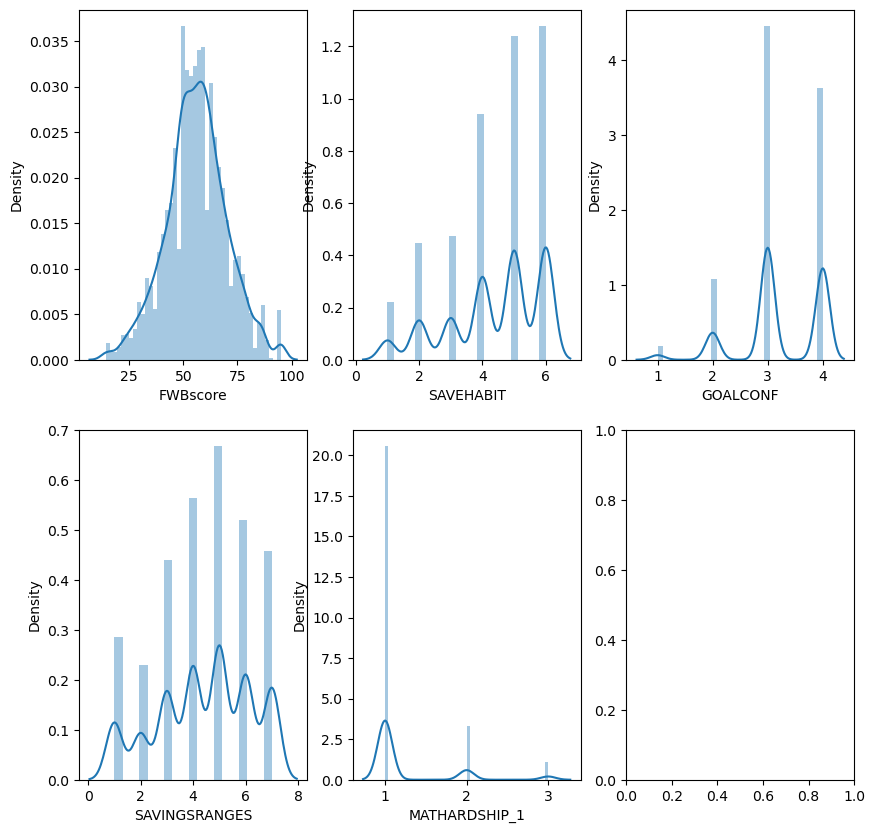

In [371]:
# plot the distribution of the numerical features

num_cols = ['FWBscore', 'SAVEHABIT', 'GOALCONF', 'SAVINGSRANGES', 'MATHARDSHIP_1']

fig, ax = plt.subplots(2, 3, figsize = (10, 10))
for i, col in enumerate(num_cols):
    sns.distplot(data[col], ax = ax[i//3, i%3])

In [372]:
gaussian_cols = ['FWBscore', 'SAVINGSRANGES']
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data[gaussian_cols])
scaled_data = pd.DataFrame(scaled_data, columns = gaussian_cols, index = data.index)

cols = ['SAVEHABIT', 'GOALCONF', 'MATHARDSHIP_1']
scaler = MinMaxScaler()
scaled_minmax = scaler.fit_transform(data[cols])
scaled_minmax = pd.DataFrame(scaled_minmax, columns = cols, index = data.index)

scaled_data = pd.concat([scaled_data, scaled_minmax, data[['COLLECT']]], axis = 1)

imputer = KNNImputerMode(n_neighbors = 5)

new_data = imputer.fit_transform(scaled_data)

new_data = pd.DataFrame(new_data, columns = scaled_data.columns, index = scaled_data.index)

In [373]:
data['COLLECT'] = new_data['COLLECT'].copy()

In [374]:
data['ABSORBSHOCK'] = data['ABSORBSHOCK'].replace(8, np.nan)

/home/inesmcm/miniconda3/envs/functionalenv/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/inesmcm/miniconda3/envs/functionalenv/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


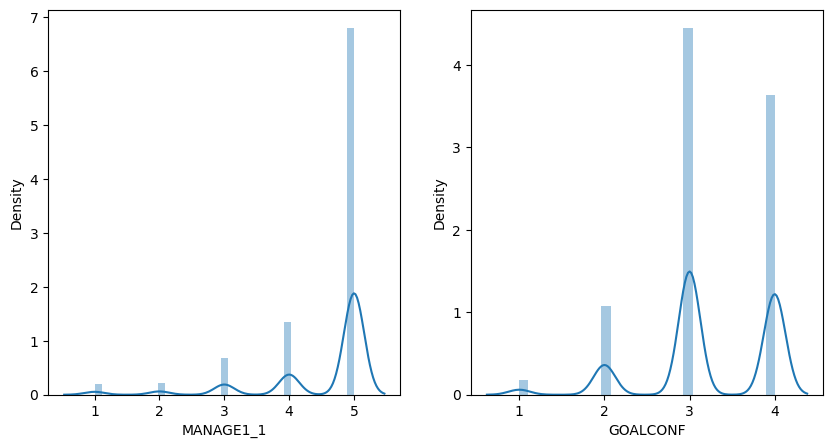

In [375]:
# plot the distribution of the numerical features

num_cols = ['MANAGE1_1', 'GOALCONF']

fig, ax = plt.subplots(1, 2, figsize = (10, 5))
for i, col in enumerate(num_cols):
    sns.distplot(data[col], ax = ax[i])

In [376]:
gaussian_cols = ['FWBscore', 'SAVINGSRANGES']
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data[gaussian_cols])
scaled_data = pd.DataFrame(scaled_data, columns = gaussian_cols, index = data.index)

cols = ['SAVEHABIT', 'MANAGE1_1', 'GOALCONF']
scaler = MinMaxScaler()
scaled_minmax = scaler.fit_transform(data[cols])
scaled_minmax = pd.DataFrame(scaled_minmax, columns = cols, index = data.index)

scaled_data = pd.concat([scaled_data, scaled_minmax, data[['ABSORBSHOCK']]], axis = 1)

imputer = KNNImputerMode(n_neighbors = 5)
new_data = imputer.fit_transform(scaled_data)
new_data = pd.DataFrame(new_data, columns = scaled_data.columns, index = scaled_data.index)

In [377]:
data['ABSORBSHOCK'] = new_data['ABSORBSHOCK'].copy()

# Questions not asked

Because respondent not in item base

PAIDHELP: only for people who have help managing money matter in the household.

If people don't have help, then they don't pay anyone to help them. So, PAIDHELP becomes 0 when MANAGE2 == 3
<br>

VALUERANGES: If you were to sell your home today, what do you think it would be worth?

Only for people who own their own house.
Same logic here! We could insert just 0 if a person does not own a home.
<br>

MORTGAGE: What do you owe on your home today?

Same logic here! We can insert just 0 if a person does not own a home.
<br>

SOCSEC1: Have you started receiving Social Security retirement benefits?

Only for people with PPAGE >= 62. If people are not equal of above 62 years old, then answer is 0.
<br>

SOCSEC2: At what age did you begin receiving benefits?

Only for people with PPAGE >= 62.
<br>

SOCSEC3: Age expect to begin receiving Social Security retirement benefits

Only for people with PPAGE < 62 or peope that not yest started receiving.
<br>

LIFEEXPECT: How likely do you believe it is that you will live beyond age 75?

Only for people with PPAGE <= 75 probabilidade 1
<br>

RETIRE: Did you retire earlier than you planned, later than you planned, or about when you planned?

In [378]:
data.loc[data['MANAGE2'] == 3, 'PAIDHELP'] = 0 # if does not have help, does not pay for it

In [379]:
data.loc[data['HOUSING'] != 1, 'VALUERANGES'] = 0 # if doesn't own a house, then the value of the house is 0

In [380]:
data.loc[data['HOUSING'] != 1, 'MORTGAGE'] = 0 # if does not own a house, mortgage is 0

In [381]:
data.loc[data['SOCSEC1'] == -2, 'SOCSEC1'] = 0 # if age < 62, answer is no

In [382]:
data.loc[data['SOCSEC1'] == 0, 'SOCSEC2'].value_counts()

-2.0    4306
Name: SOCSEC2, dtype: int64

In [383]:
data[data['SOCSEC2'] == -2].shape[0] # what to do with this??

# create another one hot for 'does not apply'?

4306

In [384]:
data.loc[data['SOCSEC3'] == -2, 'SOCSEC1'].value_counts()

# also does not make sense. all should be 1

# create another one hot for 'i don't know'?

1.0    1732
0.0     351
Name: SOCSEC1, dtype: int64

In [385]:
# its probably best to just drop SOCSEC2 AND SOCSEC3 and only keep SOCSEC1

data.drop(['SOCSEC2', 'SOCSEC3'], axis = 1, inplace = True)

In [386]:
data.loc[data['LIFEEXPECT'] == -2, 'LIFEEXPECT'] = 1 # 100% probability

In [387]:
data.loc[data['RETIRE'] == -2, 'RETIRE'] = 4 # 4th option: not retired

In [388]:
# get all rows with -2 in any column
data[data.isin([-2]).any(axis=1)].shape[0]

0

---------------------------------------------------------------------------------
Here ends preprocessing

- data is going to be used with all features
- data_engineered is going to be also used
- data_pca the same

# One hot encoding

Categorical variables: sample, AUTOMATED_1, AUTOMATED_2, HOUSING, LIVINGARRANGEMENT, COVERCOSTS, HSLOC, DISCOUNT (binary), Military_Status, generation, PPETHM, PPGENDER (binary), PPMARIT, PPREG4, PPREG9

In [389]:
print(data.shape)

(6038, 164)


In [390]:
cat_feats = ['sample', 'FINGOALS', 'AUTOMATED_1', 'AUTOMATED_2',
             'HOUSING', 'LIVINGARRANGEMENT', 'VOLATILITY',
             'SNAP', 'FRAUD2', 'COVERCOSTS', 'MANAGE2',
             'HSLOC', 'DISCOUNT', 'RETIRE', 'generation',
             'PPETHM', 'PPGENDER', 'PPMARIT', 'PPREG4',
             'PPREG9']

In [391]:
# one hot encoding
data = pd.get_dummies(data, columns = cat_feats, drop_first = True)

In [393]:
print(data.shape)

(6038, 192)


In [420]:
data.to_csv('data/preprocessed_data.csv')

# Numerical features scaling

In [394]:
data.head()

,fpl,SWB_1,SWB_2,SWB_3,FWBscore,FSscore,SUBKNOWL1,ACT1_1,ACT1_2,PROPPLAN_1,...,PPREG4_3,PPREG4_4,PPREG9_2,PPREG9_3,PPREG9_4,PPREG9_5,PPREG9_6,PPREG9_7,PPREG9_8,PPREG9_9
PUF_ID,,,,,,,,,,,,,,,,,,,,,
10350,3,5.0,5.0,6.0,55.0,44.0,5.0,4.0,3.0,5.0,...,0,1,0,0,0,0,0,0,1,0
7740,3,6.0,6.0,6.0,51.0,43.0,5.0,4.0,3.0,3.0,...,0,0,0,1,0,0,0,0,0,0
13699,3,4.0,3.0,4.0,49.0,42.0,5.0,3.0,3.0,4.0,...,0,1,0,0,0,0,0,0,0,1
7375,3,4.0,4.0,4.0,49.0,42.0,4.0,3.0,3.0,3.0,...,0,0,0,0,1,0,0,0,0,0
10910,3,5.0,7.0,5.0,67.0,57.0,6.0,5.0,4.0,5.0,...,0,0,0,1,0,0,0,0,0,0


In [406]:
# number of unqiue values in each column
cat_feats = list(data.columns[data.nunique() == 2])
num_feats = list(data.columns[data.nunique() > 2])

In [417]:
num_feats.remove('finalwt')
num_feats.remove('fpl')

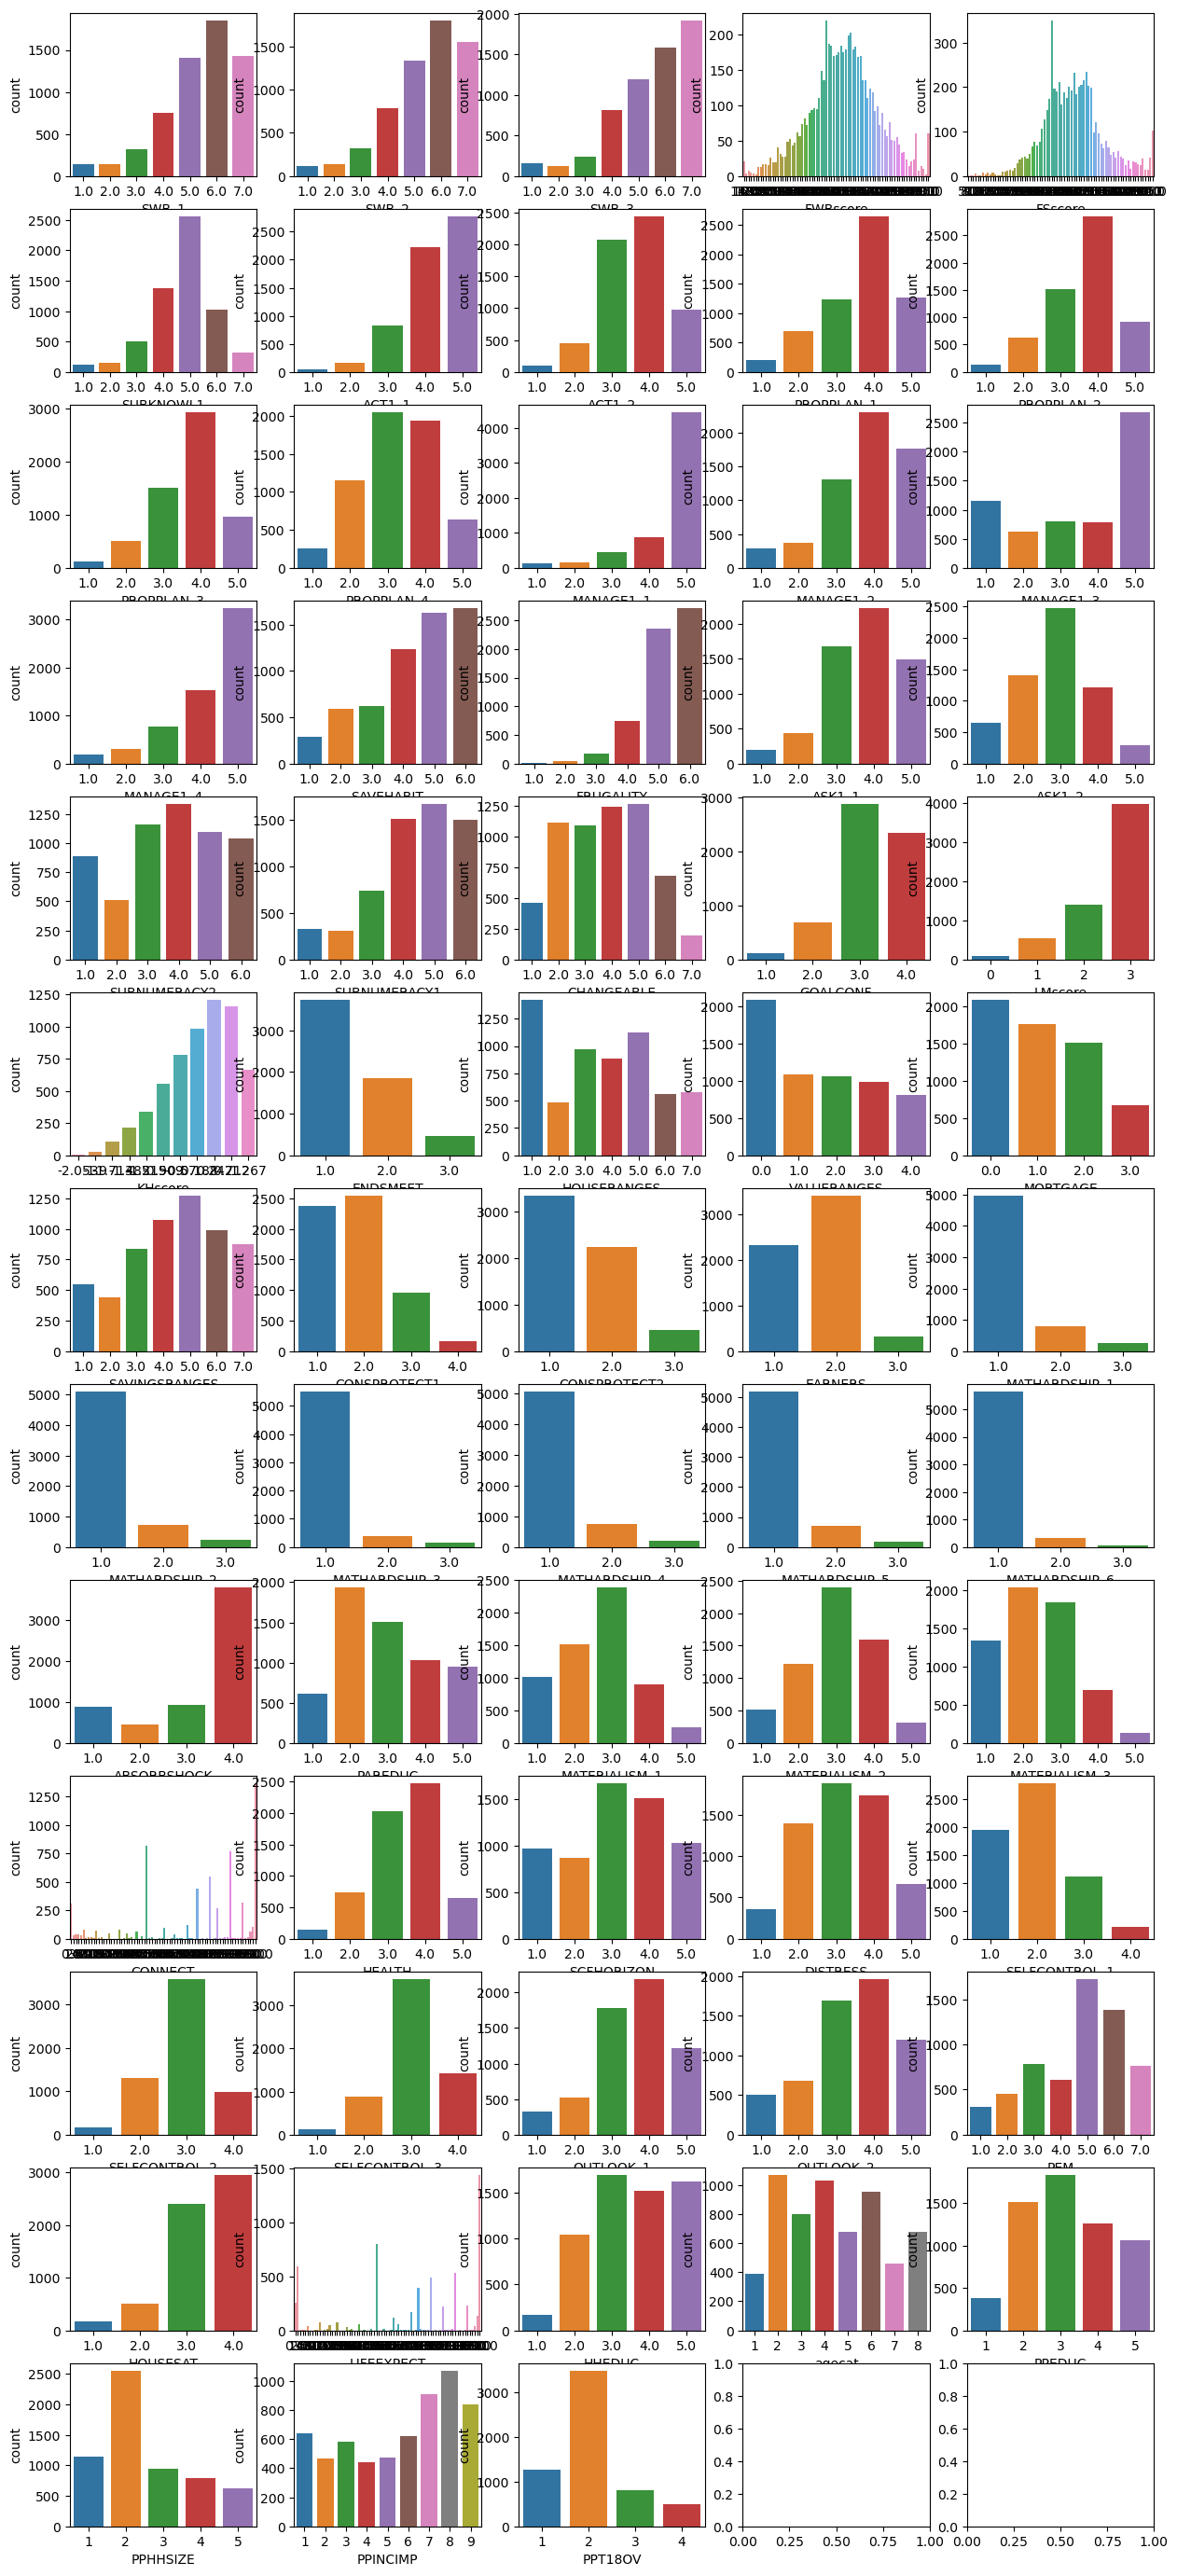

In [429]:
# plot the distribution of the numerical features

fig, ax = plt.subplots(13, 5, figsize = (15, 35))
for i, col in enumerate(num_feats):
    sns.countplot(data = data, x = col, ax = ax[i//5, i%5])

Gaussian features:

- PPEDUC
- DISTRESS
- MATERIALISM_1
- MATERIALISM_2
- ASK1_2
- FSscore
- FWBscore

In [441]:
data

,fpl,SWB_1,SWB_2,SWB_3,FWBscore,FSscore,SUBKNOWL1,ACT1_1,ACT1_2,PROPPLAN_1,...,PPREG4_3,PPREG4_4,PPREG9_2,PPREG9_3,PPREG9_4,PPREG9_5,PPREG9_6,PPREG9_7,PPREG9_8,PPREG9_9
PUF_ID,,,,,,,,,,,,,,,,,,,,,
10350,3,5.0,5.0,6.0,55.0,44.0,5.0,4.0,3.0,5.0,...,0,1,0,0,0,0,0,0,1,0
7740,3,6.0,6.0,6.0,51.0,43.0,5.0,4.0,3.0,3.0,...,0,0,0,1,0,0,0,0,0,0
13699,3,4.0,3.0,4.0,49.0,42.0,5.0,3.0,3.0,4.0,...,0,1,0,0,0,0,0,0,0,1
7375,3,4.0,4.0,4.0,49.0,42.0,4.0,3.0,3.0,3.0,...,0,0,0,0,1,0,0,0,0,0
10910,3,5.0,7.0,5.0,67.0,57.0,6.0,5.0,4.0,5.0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11620,2,7.0,6.0,7.0,44.0,45.0,5.0,4.0,3.0,4.0,...,0,1,0,0,0,0,0,0,0,1
11220,3,6.0,7.0,7.0,61.0,47.0,5.0,5.0,4.0,3.0,...,0,0,0,1,0,0,0,0,0,0
8709,3,5.0,6.0,6.0,59.0,51.0,4.0,4.0,4.0,5.0,...,0,0,1,0,0,0,0,0,0,0
